# Initial Pass Set Kick Speed for OTs Projects 




## Introduction
While spectators usually do not give Offensive Tackles (OT) the glory, they are the unsung heroes of the game. Their job is to protect the outside of the line of scrimmage and the blind side of the Quarterback (QB) or the side that the QB is not facing. These tackles must be strong, but also quick enough to stop pass rushers from sacking the QB. The ultimate goal for the tackle is to beat the rusher to a power spot, where he can position himself at an advantage when acquiring a half-man relationship with his opponent. This half-man relationship ultimately determines if the rusher will be able to win at all on the inside or outside.

Thus, the initial pass-set kick speed of an OT dropping into his kick slide is crucial when working against a pass rusher. We have created two variations (90th percentile kick speed and mean kick speed) of a metric that measure the acceleration of an OT within 0.5 seconds of the team snapping the ball. 


## Hypothesis
For our hypothesis, we predicted that the initial pass-set kick speed of OTs influences how they perform throughout the rest of the play. Our theory is that the initial kick speed aids in the OT's ability to beat the pass rusher to the half-man relationship power spot.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

blockers_accel_mean = pd.read_csv("kaggle/input/blockers_top_10_acceleration/blockers_top_10_acceleration.csv")
blockers_accel_90 = pd.read_csv("kaggle/input/blockers_top_10_acceleration_90_percentile/blockers_top_10_acceleration_90_percentile.csv")
blockers = pd.read_csv("kaggle/input/blockers/blockers.csv")
play1_plays = pd.read_csv("kaggle/input/play1/play1_plays.csv")
play1_tracking = pd.read_csv("kaggle/input/play1/play1_trackingdf.csv")
play0_plays = pd.read_csv("kaggle/input/play0/play2_plays.csv")
play0_tracking = pd.read_csv("kaggle/input/play0/play2_trackingdf.csv")
play3_plays = pd.read_csv("kaggle/input/play3/play3_plays.csv")
play3_tracking = pd.read_csv("kaggle/input/play3/play3_trackingdf.csv")


In [38]:
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

## Data Processing
The data used to create the metric includes all plays in which the pass rusher is trying to beat an Offensive Tackle on the outside from the 2021-2022 NFL season. We limited the outside plays to account for standard pass protection snaps, without RPOs, rollouts, etc). Therefore we could purely isolate plays where the tackle is setting quickly.

Using these plays, we specifically inspect the first five frames after the Offensive Team snaps the ball to calculate the initial pass-set kick speed of the tackle. Any frames referenced after that are used in the analysis to determine if the OT contributed to the allowed sack or hurry.

When cleaning the data, we confined the metric to exclusively consider OTs who qualified for the metric on at least 50 plays. 

When creating the metric we also viewed a couple plays such as the below to determine when the pass rusher attempted to beat the OT on the outside. 

In [39]:
def animate_play(tracking_players_df, play_df, gameId, playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy() 
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
  

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    play_direction = selected_tracking_df.playDirection.values[0]
    #play_direction = selected_play_df.playDirection.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])
    selected_tracking_df['o']
     
   # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # adds some text
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Displaces the down marker based on direction
        if play_direction == 'left':
            # print('play ran')
            first_down_marker = line_of_scrimmage - selected_play_df.yardsToGo.values[0]
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],
                                       mode = 'markers',
                                       marker={'size':12, 'opacity':0.7},
                                       marker_color=colors[team],
                                       name=team,
                                       hovertext=hover_text_array,
                                       hoverinfo="text"))
                
                #dir_radians = (3.14159263535 / 180) * plot_df["dir"]
                #plot_df["x_change"] = plot_df["x"] + (plot_df["s"] * np.sin(dir_radians))
                #plot_df["y_change"] = plot_df["y"] + (plot_df["s"] * np.cos(dir_radians))
                o_radians = (3.14159263535 / 180) * plot_df["o"]
                plot_df["x_change"] = plot_df["x"] + (plot_df["s"] * np.sin(o_radians))
                plot_df["y_change"] = plot_df["y"] + (plot_df["s"] * np.cos(o_radians))
                
                x_diffs = plot_df[["x", "x_change"]].values.tolist()
                y_diffs = plot_df[["y", "y_change"]].values.tolist()
                
                for index, value in enumerate(x_diffs):
                    data.append(go.Scatter(x=x_diffs[index], 
                                           y=y_diffs[index],
                                           showlegend=False,
                                           line_color=colors[team]
                                          ))
                
            else:
                data.append(go.Scatter(x=plot_df["x"], 
                                       y=plot_df["y"],
                                       mode = 'markers',
                                       marker_color=colors[team],
                                       name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )
    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

Below are two examples of standard pass plays used where the Offensive Tackles are just protecting the edge against an outside rusher. These are examples of the plays we used in determining the mean and 90th percentile kick speed.

In [40]:
animate_play(play1_tracking,play1_plays, 2021103106,4109).show()

In [41]:
animate_play(play0_tracking,play0_plays,2021091910,2074).show()

## Initial Pass Set Kick Speed Metric Derivation

Mean Kick Speed (Variation 1):

In the first variation of the metric, we calculated the average max acceleration of the OTs within the first 5 frames after the offense snapped the ball.

90th Percentile Kick Speed (Variation 2): 

In the second variation of the metric, we isolated and averaged the 90th percentile kick speeds of Variation 1 to account for any other plays skewing the data where the OT was not intentionally attempting a quick kick speed.


In [42]:
blockers.drop('nflId', axis=1, inplace=True)

In [43]:
blockers.sort_values(by='mean_kick', ascending=False, ).rename(columns={"pff_positionLinedUp": "position", "displayName": "name","nPlays": "number_of_plays"}).round(2).head(10)

,position,name,team,number_of_plays,mean_kick,beatRateAllowed,hitRateAllowed,hurryRateAllowed,sackRateAllowed,90p_kick,pressureRate
80,LT,Christian Darrisaw,MIN,45,3.98,0.11,0.00,0.02,0.00,5.81,0.02
1,LT,Andrew Whitworth,LA,135,3.22,0.05,0.01,0.03,0.00,5.44,0.04
30,LT,Ronnie Stanley,BAL,25,3.07,0.16,0.04,0.32,0.00,4.22,0.36
83,RT,Samuel Cosmi,WAS,54,2.90,0.09,0.02,0.00,0.02,3.89,0.04
34,RT,Brandon Shell,SEA,53,2.89,0.02,0.02,0.08,0.02,4.46,0.11
17,LT,Jake Matthews,ATL,160,2.80,0.04,0.01,0.04,0.00,4.49,0.05
78,LT,Rashawn Slater,LAC,173,2.79,0.08,0.01,0.05,0.01,4.00,0.06
3,LT,Trent Williams,SF,103,2.79,0.05,0.01,0.03,0.00,4.33,0.04
82,RT,Liam Eichenberg,MIA,41,2.74,0.07,0.00,0.12,0.00,4.84,0.12
76,RT,Terence Steele,DAL,70,2.74,0.07,0.01,0.06,0.00,4.60,0.07


The above chart ranks all OTs by their Mean Kickspeed (Variation 1)

In [44]:
blockers.sort_values(by='90p_kick', ascending=False, ).rename(columns={"pff_positionLinedUp": "position", "displayName": "name","nPlays": "number_of_plays"}).round(2).head(10)

,position,name,team,number_of_plays,mean_kick,beatRateAllowed,hitRateAllowed,hurryRateAllowed,sackRateAllowed,90p_kick,pressureRate
80,LT,Christian Darrisaw,MIN,45,3.98,0.11,0.00,0.02,0.00,5.81,0.02
1,LT,Andrew Whitworth,LA,135,3.22,0.05,0.01,0.03,0.00,5.44,0.04
82,RT,Liam Eichenberg,MIA,41,2.74,0.07,0.00,0.12,0.00,4.84,0.12
76,RT,Terence Steele,DAL,70,2.74,0.07,0.01,0.06,0.00,4.60,0.07
17,LT,Jake Matthews,ATL,160,2.80,0.04,0.01,0.04,0.00,4.49,0.05
34,RT,Brandon Shell,SEA,53,2.89,0.02,0.02,0.08,0.02,4.46,0.11
63,RT,Patrick Mekari,BAL,64,2.35,0.08,0.00,0.02,0.02,4.39,0.03
3,LT,Trent Williams,SF,103,2.79,0.05,0.01,0.03,0.00,4.33,0.04
30,LT,Ronnie Stanley,BAL,25,3.07,0.16,0.04,0.32,0.00,4.22,0.36
51,LT,Geron Christian,HOU,80,2.65,0.06,0.00,0.06,0.00,4.12,0.06


The above chart ranks all OTs by their 90-percentile Kickspeed (Variation 2).

## Analysis
We wanted to determine if there was a correlation between kick speeds and different types of quarterback pressure. For each qualifying player, we aggregated the types of pressure allowed.

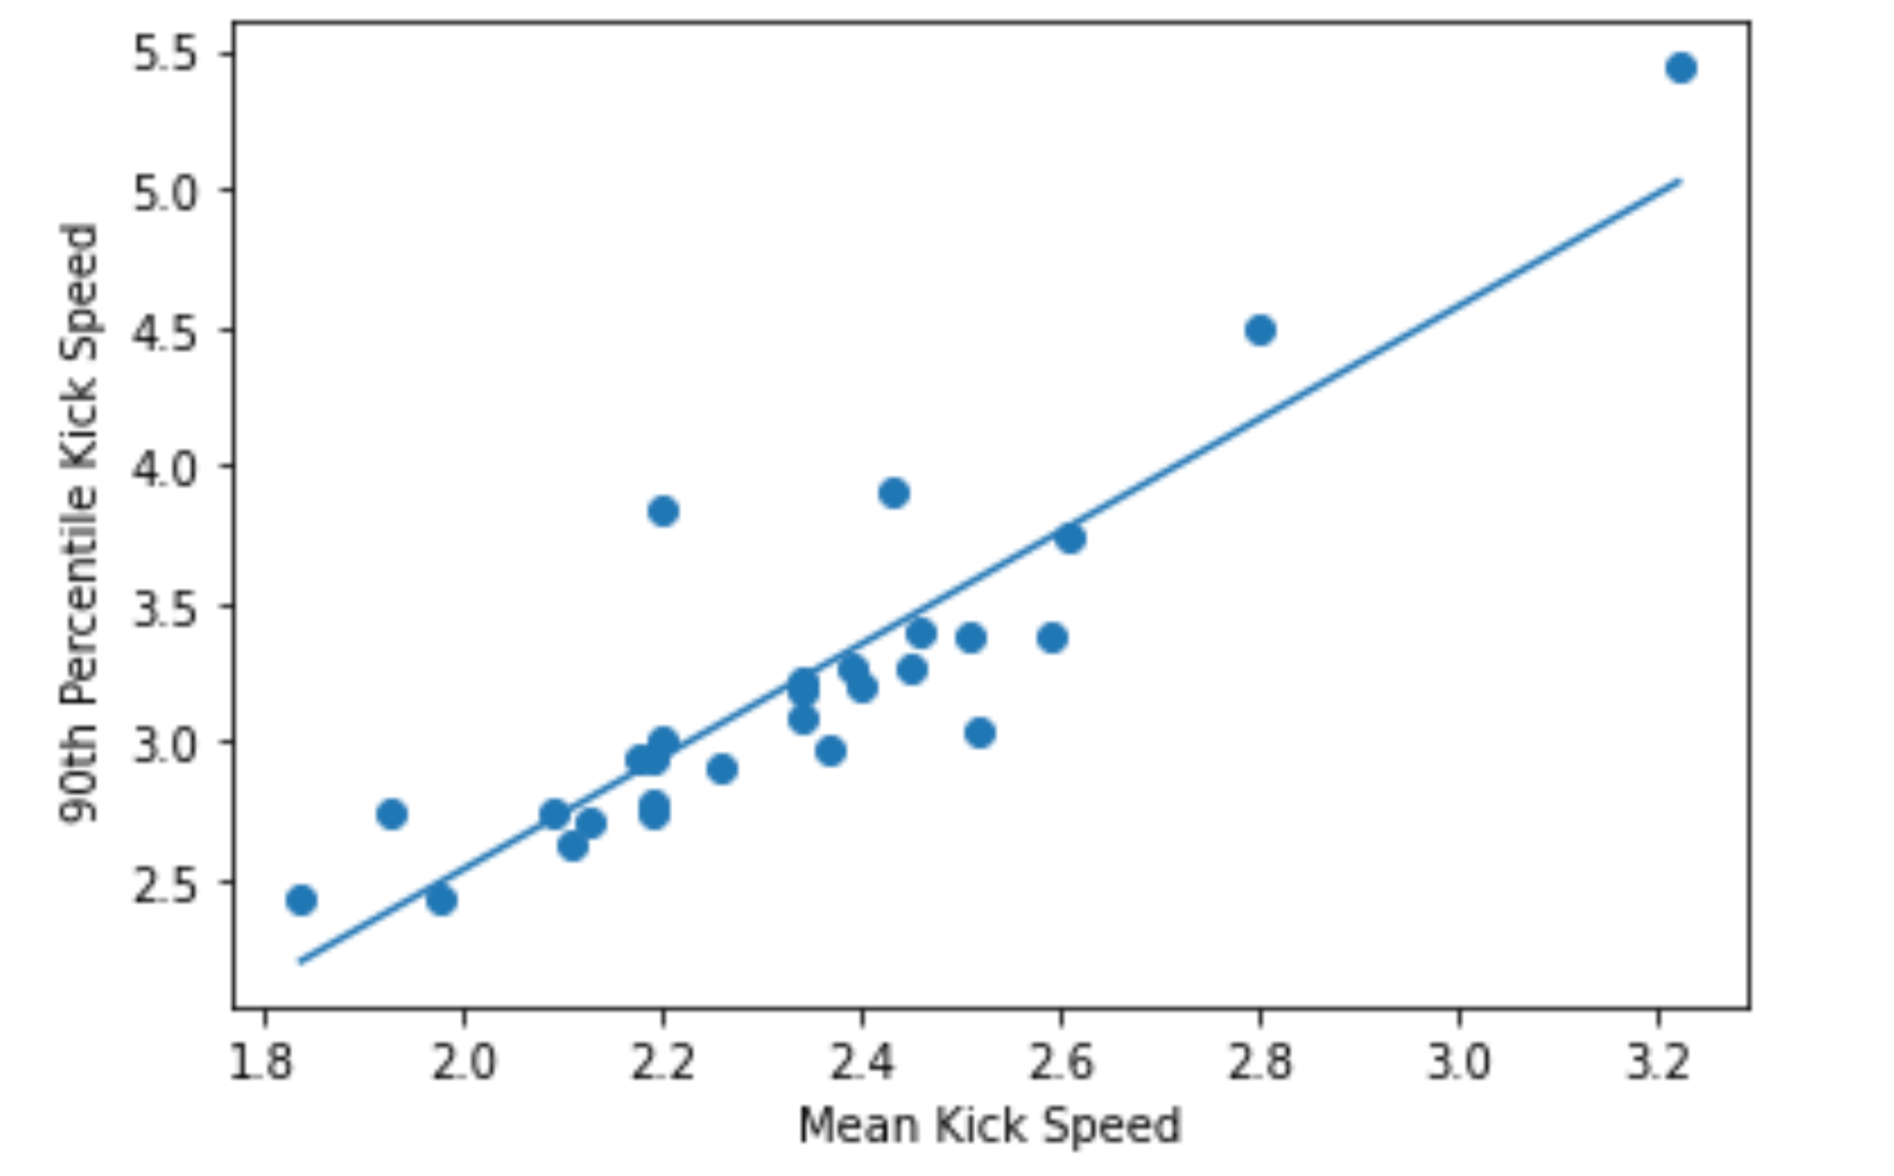

This plot indicates a strong correlation between both of the stats we created.


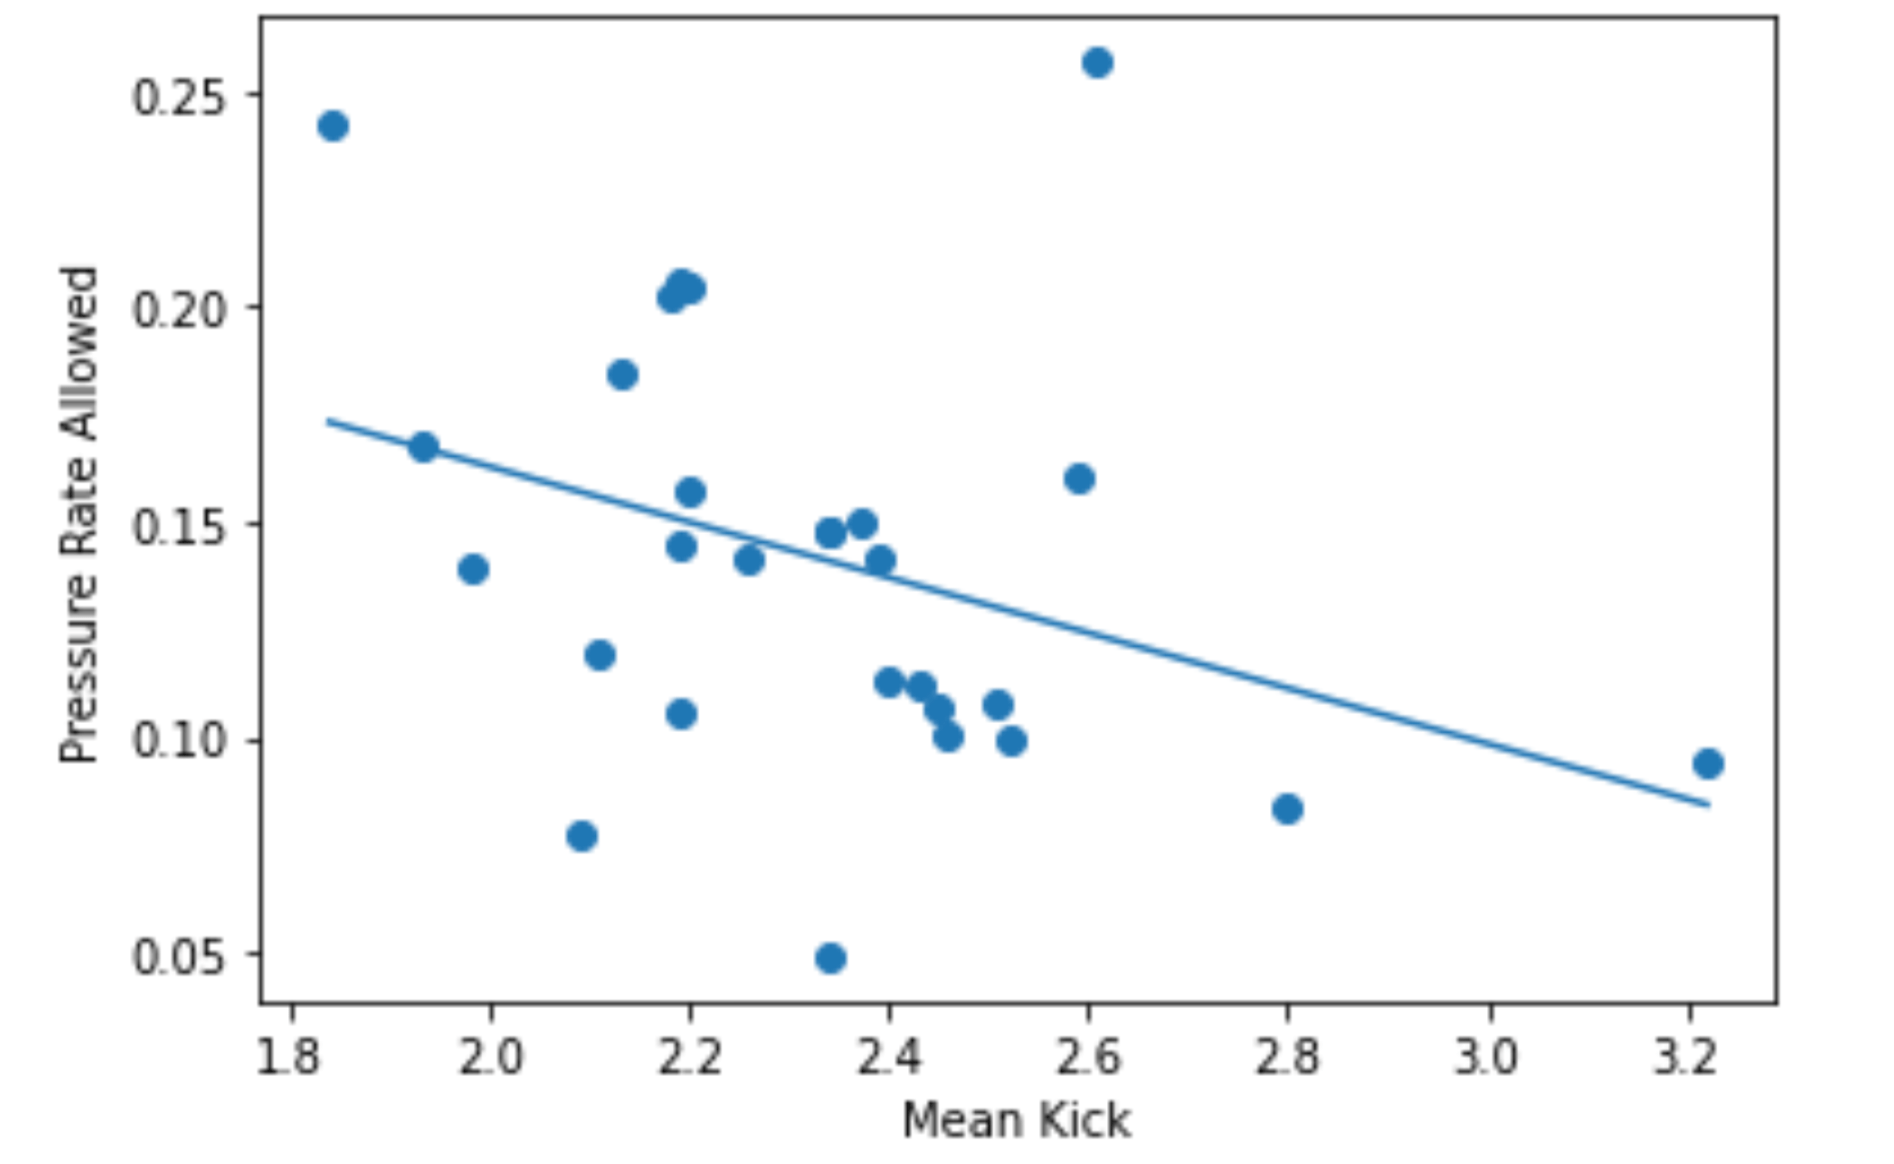

Above you can see that there is a negative correlation between the pressure rate allowed and the mean kick speed. In other words, a faster kick speed of the OT indicates less pressure allowed by the pass rusher. 


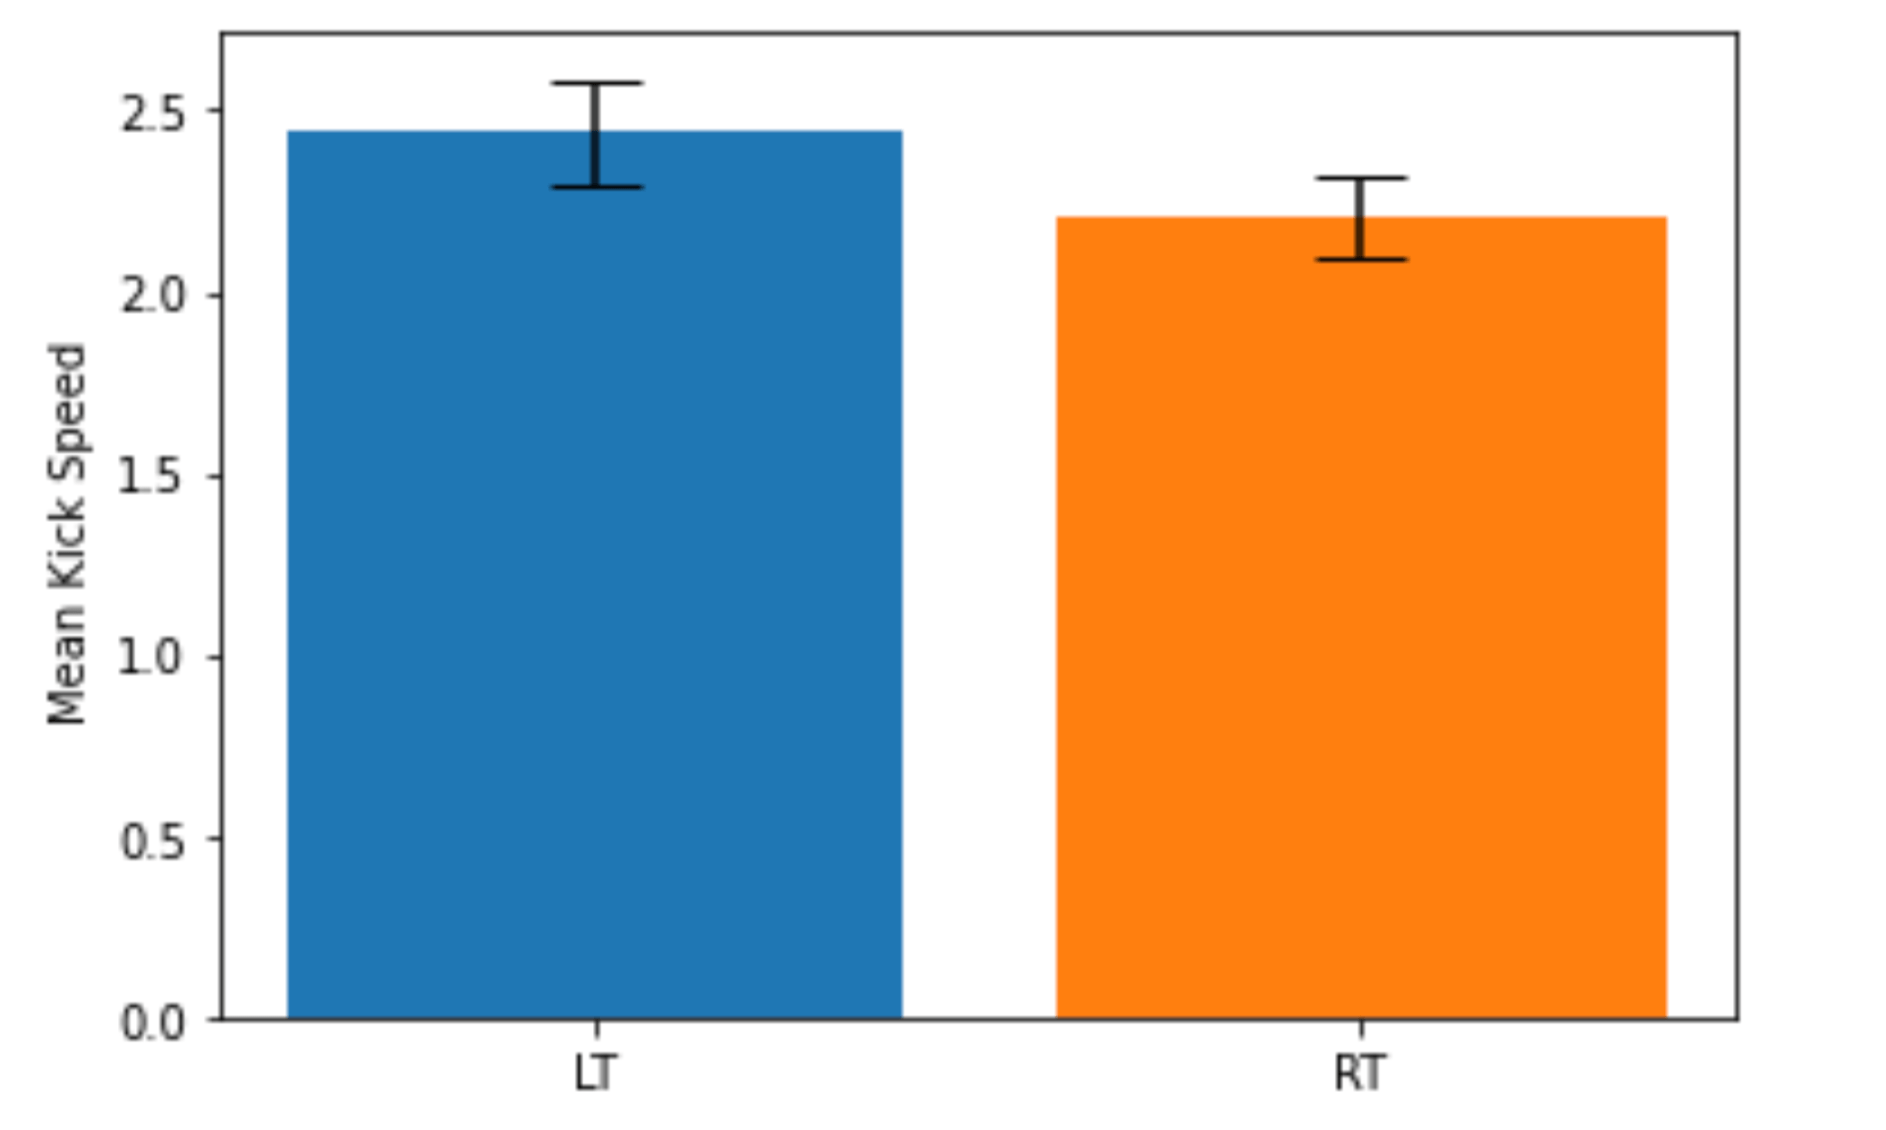

The above chart calculates a 95 percentile confidence interval for the average mean kick speed of Left Tackles and Right Tackles with a standard deviation of 1.96. Overall, Left Tackles tend to have a faster kick speed than Right Tackles.

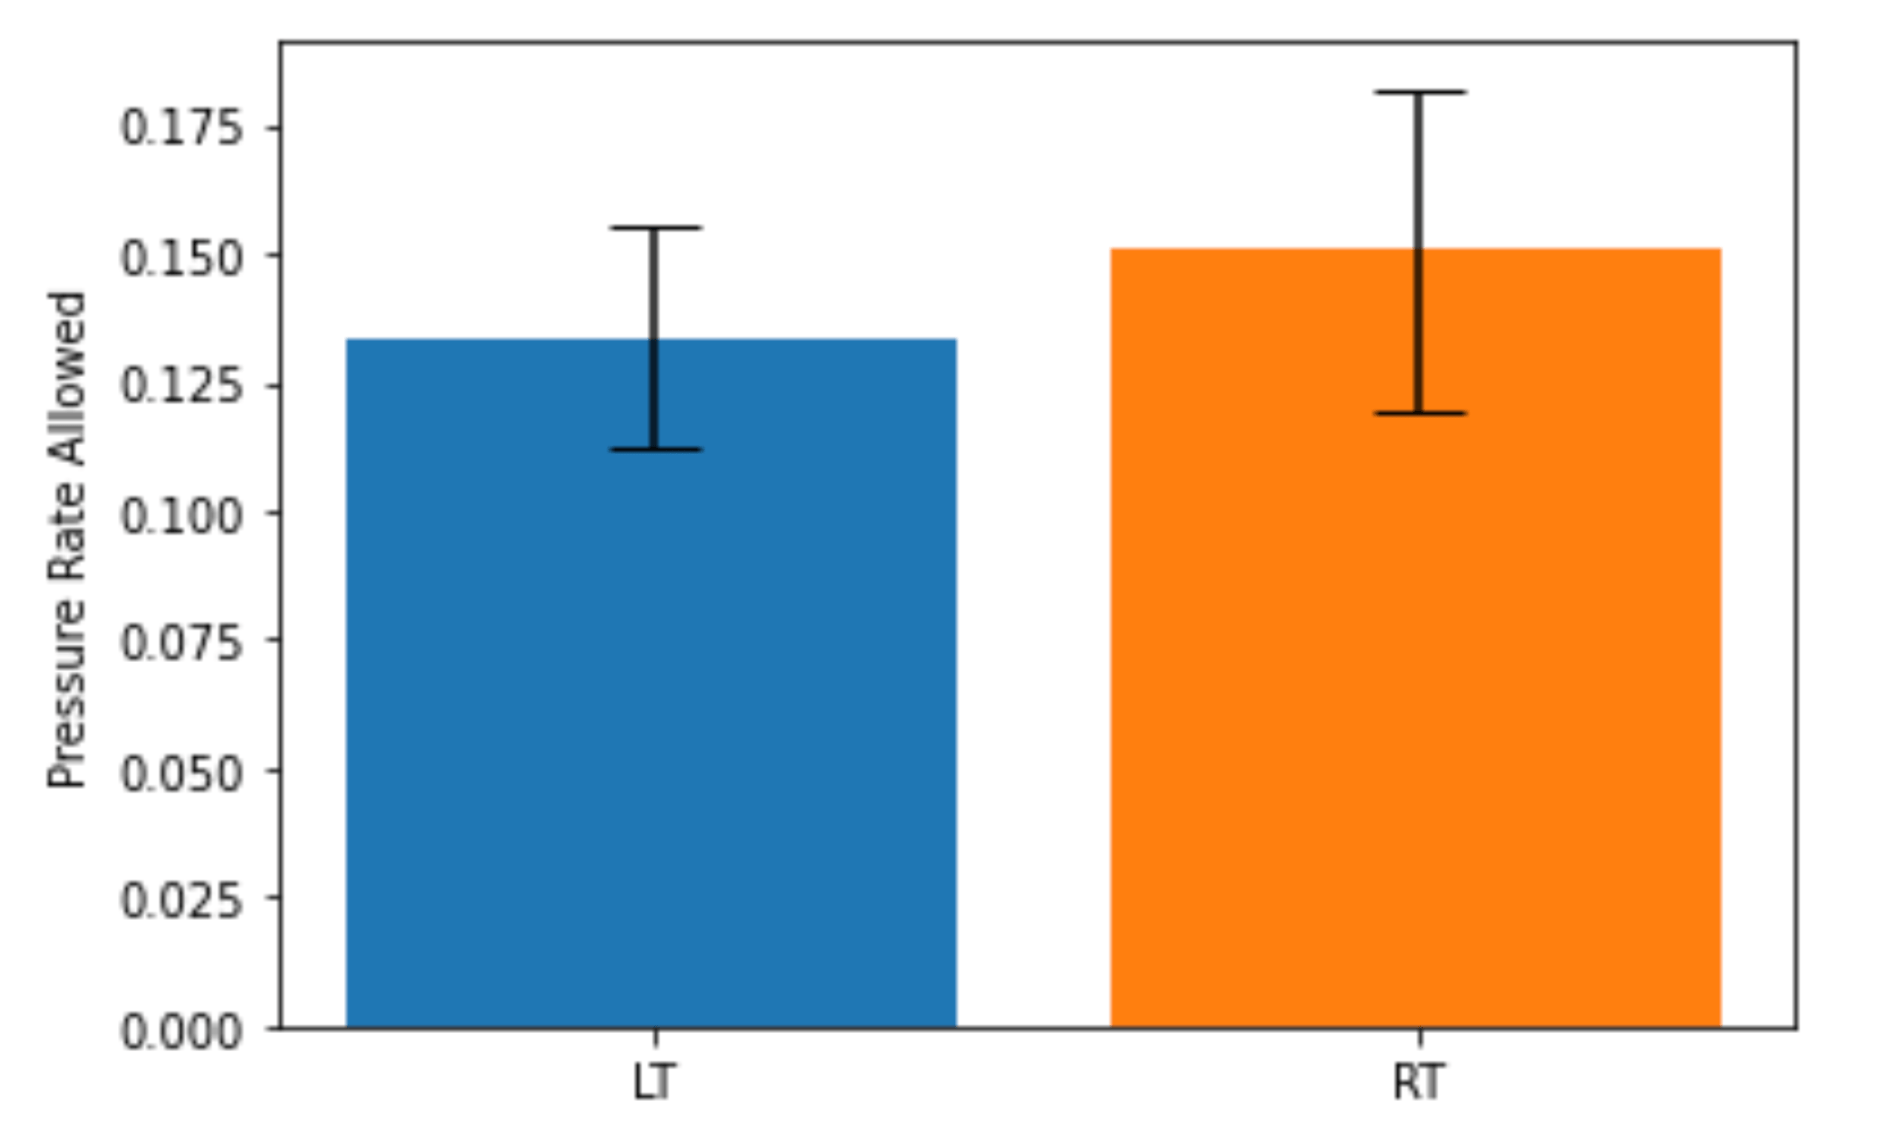

The (albeit minimal) overlap between 95% confidence intervals indicates that while LTs generally outperformed RTs in kick speed during the first 8 weeks of the season, this might not be statistically significant. RTs also generally allowed a higher pressure rate during this time, although this is not statistically significant from LTs, and more data is needed.

If statistically significant, there might be other factors that allow for an RT to get away with having a slightly lower kick speed than an LT. As previously mentioned, the LT is generally on the QB's blind side. Thus it's more important for them to establish control—as the QB can't see the defender coming. For RTs, the QB might be able to get away with slightly less protection from the side if they can see the defender coming.

Here you can see the play with the fastest kick speed we had access to. As you can see the left tackle is moving considerably faster than the right tackle.

In [9]:
animate_play(play3_tracking,play3_plays,2021091910,3027).show()

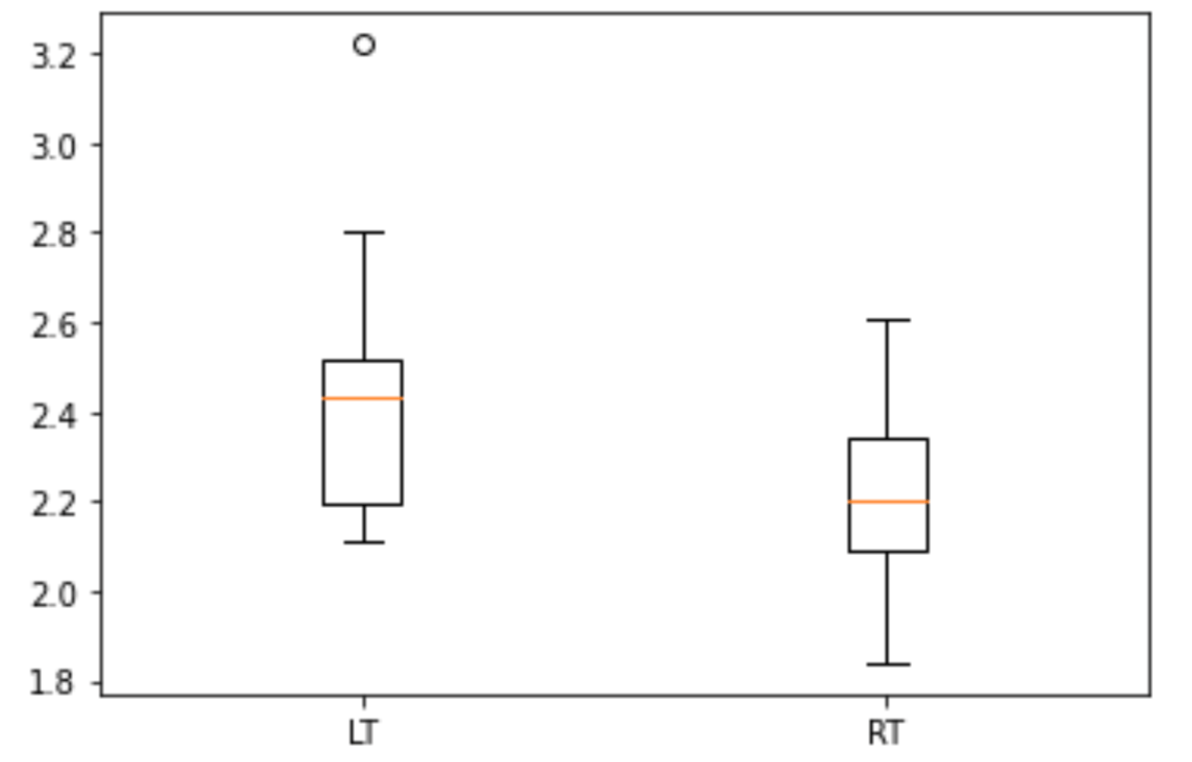

## Conclusion
We believe this metric shows promising signs, however strong statistical significance could not be proved, likely due to more data being required. The reason we believe this could be a promising metric is because of the strong negative correlation between the pressure rate allowed and the mean kick speed of Offensive Tackles. 

We calculated the pressure rate allowed by summing up pff_beatenByDefender + pff_hitAllowed + pff_hurryAllowed + pff_sackAllowed. However, the metric tends to struggle when directly correlated to pff_beatenByDefender, pff_hitAllowed, pff_hurryAllowed, or pff_sackAllowed allowed. 

For example, the mean kick speed's correlations to sacks allowed have an R^2 of 0.253389777318258, a P value of 0.006321170890592978, and a Std. Error 1.0049042395573458. This does not indicate any strong relationship between the two. 




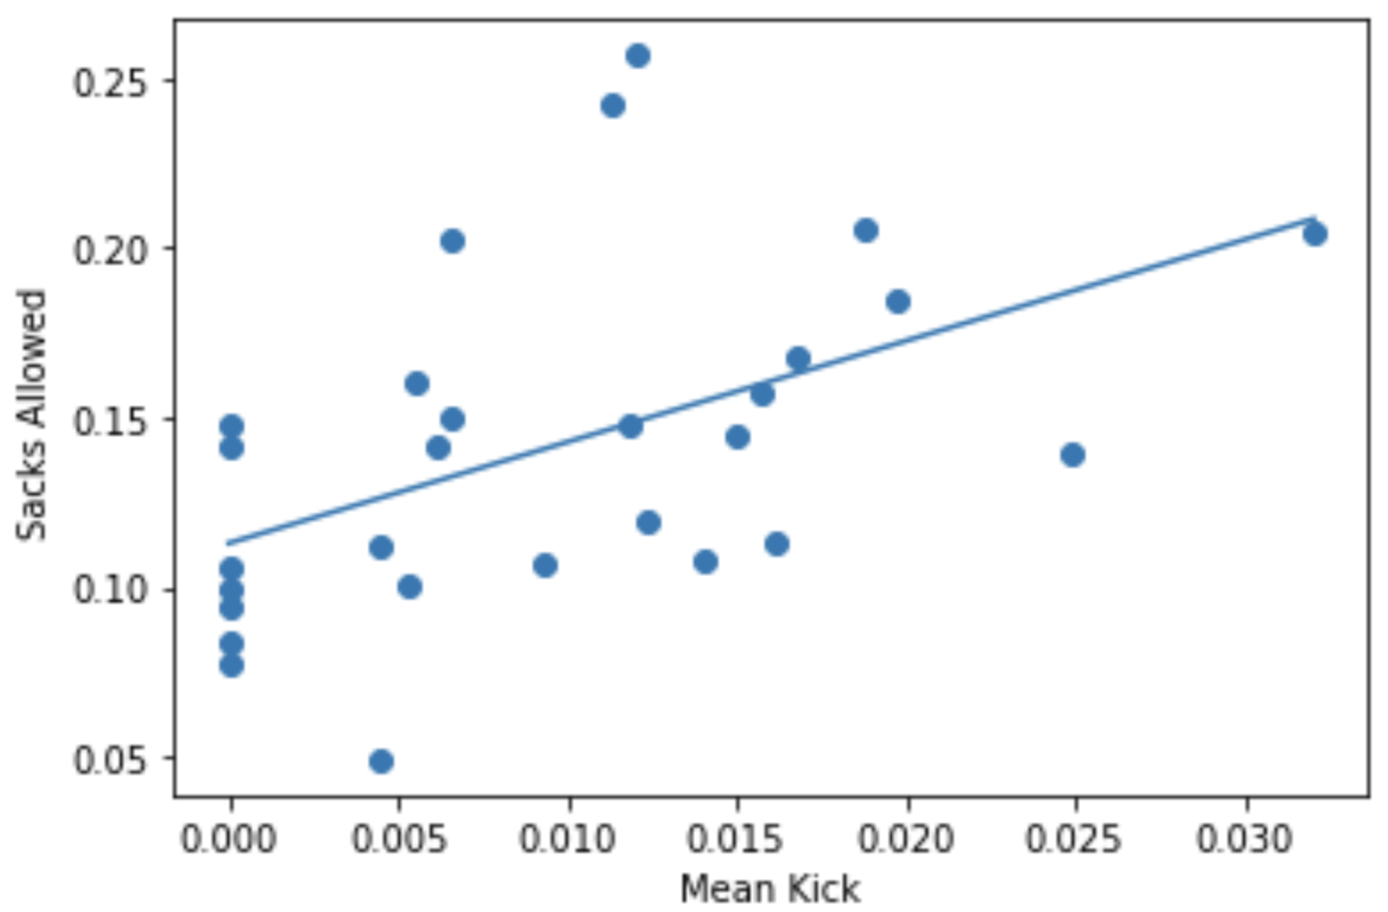

Thus, we think the metric has the potential to be useful, but it needs more data to strengthen its ability to be impactful.


## Appendix

Advisor: Juhun

Authors: 

Play Animation Generator: We modified Hunter KempF's [Animated (and interactive) NFL Plays in Plotly](https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly) to animate our plays.